In [3]:
import praw
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import redditharbor.login as login

from tqdm.notebook import tqdm
from collections import Counter

In [4]:
REDDIT_PUBLIC = "9zk3ptJvrNihAEGiiyTYPg"
REDDIT_SECRET = "dpYAGYqjV3jfcdg7bNjXJ9gX99cOuQ"
REDDIT_USER_AGENT = "berkeley:network-analysis (u/stuffingmybrain)"
reddit_client = login.reddit(public_key=REDDIT_PUBLIC, secret_key=REDDIT_SECRET, user_agent=REDDIT_USER_AGENT)

[08:25:47] Using existing Reddit credentials.                                                          ]8;id=302117;file:///Users/vivrd/miniconda3/envs/network_research/lib/python3.9/site-packages/redditharbor/login.py\login.py]8;;\:]8;id=10207;file:///Users/vivrd/miniconda3/envs/network_research/lib/python3.9/site-packages/redditharbor/login.py#130\130]8;;\

           Connected to Reddit successfully.                                                           ]8;id=620344;file:///Users/vivrd/miniconda3/envs/network_research/lib/python3.9/site-packages/redditharbor/login.py\login.py]8;;\:]8;id=464194;file:///Users/vivrd/miniconda3/envs/network_research/lib/python3.9/site-packages/redditharbor/login.py#131\131]8;;\

### Construct Social Network

In [2]:
comments_df = pd.read_csv('data/reddit_database_exports/test_comment_rows.csv')
redditors_df = pd.read_csv('data/reddit_database_exports/test_redditor_rows.csv')
submissions_df = pd.read_csv('data/reddit_database_exports/test_submission_rows.csv')
comments_df.shape, redditors_df.shape, submissions_df.shape

((57568, 10), (13301, 8), (4056, 17))

In [4]:
print("comments df columns: {}".format(comments_df.columns))
print("redditors df columns: {}".format(redditors_df.columns))
print("submissions df columns: {}".format(submissions_df.columns))

comments df columns: Index(['comment_id', 'link_id', 'subreddit', 'parent_id', 'redditor_id',
       'created_at', 'body', 'score', 'edited', 'removed'],
      dtype='object')
redditors df columns: Index(['redditor_id', 'name', 'created_at', 'karma', 'is_gold', 'is_mod',
       'trophy', 'removed'],
      dtype='object')
submissions df columns: Index(['submission_id', 'redditor_id', 'created_at', 'title', 'text',
       'subreddit', 'permalink', 'attachment', 'flair', 'awards', 'score',
       'upvote_ratio', 'num_comments', 'edited', 'archived', 'removed',
       'poll'],
      dtype='object')


In [19]:
def find_most_active_subreddit(username):
    # Fetch the user by username
    user = reddit_client.redditor(username)
    
    # Initialize a counter to keep track of subreddits
    subreddit_counter = Counter()
    
    # Iterate through the user's submissions and comments (limit to the last 100 of each)
    for submission in user.submissions.new(limit=1000):
        subreddit_counter[submission.subreddit.display_name] += 1

    for comment in user.comments.new(limit=100):
        subreddit_counter[comment.subreddit.display_name] += 1

    # Find the most common subreddit and the number of activities (posts + comments)
    most_common_subreddit, activity_count = subreddit_counter.most_common(1)[0]
    
    return most_common_subreddit, activity_count

In [20]:
find_most_active_subreddit("stuffingmybrain")

('berkeley', 119)

In [5]:
# Initialize a directed graph
G = nx.DiGraph()

# Add nodes with subreddit attribute
for _, row in tqdm(redditors_df.iterrows(), total=redditors_df.shape[0], desc="Processing Redditors"):
    subreddit = "N/A"  # Default value
    redditor_id = row['redditor_id']

    # Check if the redditor has made any submissions
    if redditor_id in submissions_df['redditor_id'].values:
        subreddit = submissions_df[submissions_df['redditor_id'] == redditor_id]['subreddit'].iloc[0]

    # Check if the redditor has made any comments
    elif redditor_id in comments_df['redditor_id'].values:
        subreddit = comments_df[comments_df['redditor_id'] == redditor_id]['subreddit'].iloc[0]

    # Add node to the graph
    G.add_node(redditor_id, subreddit=subreddit)

# Add edges based on submissions and comments
for _, row in tqdm(comments_df.iterrows(), total=comments_df.shape[0], desc="Processing Comments"):
    commenter = row['redditor_id']
    submission_id = row['link_id']

    if submission_id in submissions_df['submission_id'].values:
        submitter = submissions_df[submissions_df['submission_id'] == submission_id]['redditor_id'].iloc[0]
        G.add_edge(commenter, submitter)

for _, row in tqdm(comments_df.iterrows(), total=comments_df.shape[0], desc="Processing Comment Replies"):
    commenter = row['redditor_id']
    parent_id = row['parent_id']

    # Check if parent_id is a comment
    if parent_id.startswith('t1_') and parent_id in comments_df['comment_id'].values:
        parent_commenter = comments_df[comments_df['comment_id'] == parent_id]['redditor_id'].iloc[0]
        G.add_edge(commenter, parent_commenter)

Processing Redditors:   0%|          | 0/13301 [00:00<?, ?it/s]

Processing Comments:   0%|          | 0/57568 [00:00<?, ?it/s]

Processing Comment Replies:   0%|          | 0/57568 [00:00<?, ?it/s]

In [6]:
G = nx.Graph()

# Add nodes with subreddit attribute
for _, row in redditors_df.iterrows():
    subreddit = "N/A"  # Default value
    redditor_id = row['redditor_id']

    # Check if the redditor has made any submissions
    if redditor_id in submissions_df['redditor_id'].values:
        subreddit = submissions_df[submissions_df['redditor_id'] == redditor_id]['subreddit'].iloc[0]

    # Check if the redditor has made any comments
    elif redditor_id in comments_df['redditor_id'].values:
        subreddit = comments_df[comments_df['redditor_id'] == redditor_id]['subreddit'].iloc[0]

    # Add node to the graph with subreddit attribute
    G.add_node(redditor_id, subreddit=subreddit)

# Add edges based on submissions and comments
for _, row in comments_df.iterrows():
    commenter = row['redditor_id']
    submission_id = row['link_id']

    if submission_id in submissions_df['submission_id'].values:
        submitter = submissions_df[submissions_df['submission_id'] == submission_id]['redditor_id'].iloc[0]
        G.add_edge(commenter, submitter)

for _, row in comments_df.iterrows():
    commenter = row['redditor_id']
    parent_id = row['parent_id']

    # Check if parent_id is a comment
    if parent_id.startswith('t1_') and parent_id in comments_df['comment_id'].values:
        parent_commenter = comments_df[comments_df['comment_id'] == parent_id]['redditor_id'].iloc[0]
        G.add_edge(commenter, parent_commenter)

# Network Analysis Metrics
num_connected_components = nx.number_connected_components(G)
average_degree = sum(dict(G.degree()).values()) / len(G)
density = nx.density(G)

print(f"Number of Connected Components: {num_connected_components}")
print(f"Average Degree: {average_degree}")
print(f"Network Density: {density}")

if num_connected_components == 1:
    average_path_length = nx.average_shortest_path_length(G)
    diameter = nx.diameter(G)
    print(f"Average Path Length: {average_path_length}")
    print(f"Diameter of the Graph: {diameter}")
else:
    print("Graph is not connected, average path length and diameter are not defined.")

clustering_coefficient = nx.average_clustering(G)
print(f"Clustering Coefficient: {clustering_coefficient}")

Number of Connected Components: 77
Average Degree: 3.0831453916704255
Network Density: 0.00023179801456059136
Graph is not connected, average path length and diameter are not defined.
Clustering Coefficient: 0.06722230051043698


In [8]:
G.remove_edges_from(nx.selfloop_edges(G))
G_kcore = nx.k_core(G, k=3)

In [9]:
# Add subreddit attributes to nodes in G
for _, row in redditors_df.iterrows():
    subreddit = "N/A"  # Default value
    redditor_id = row['redditor_id']

    if redditor_id in submissions_df['redditor_id'].values:
        subreddit = submissions_df[submissions_df['redditor_id'] == redditor_id]['subreddit'].iloc[0]
    elif redditor_id in comments_df['redditor_id'].values:
        subreddit = comments_df[comments_df['redditor_id'] == redditor_id]['subreddit'].iloc[0]

    G.nodes[redditor_id]['subreddit'] = subreddit

# Create the k-core subgraph
G_kcore = nx.k_core(G, k=3)

# Ensure that subreddit attributes are transferred to G_kcore
for node in G_kcore:
    if 'subreddit' in G.nodes[node]:
        G_kcore.nodes[node]['subreddit'] = G.nodes[node]['subreddit']

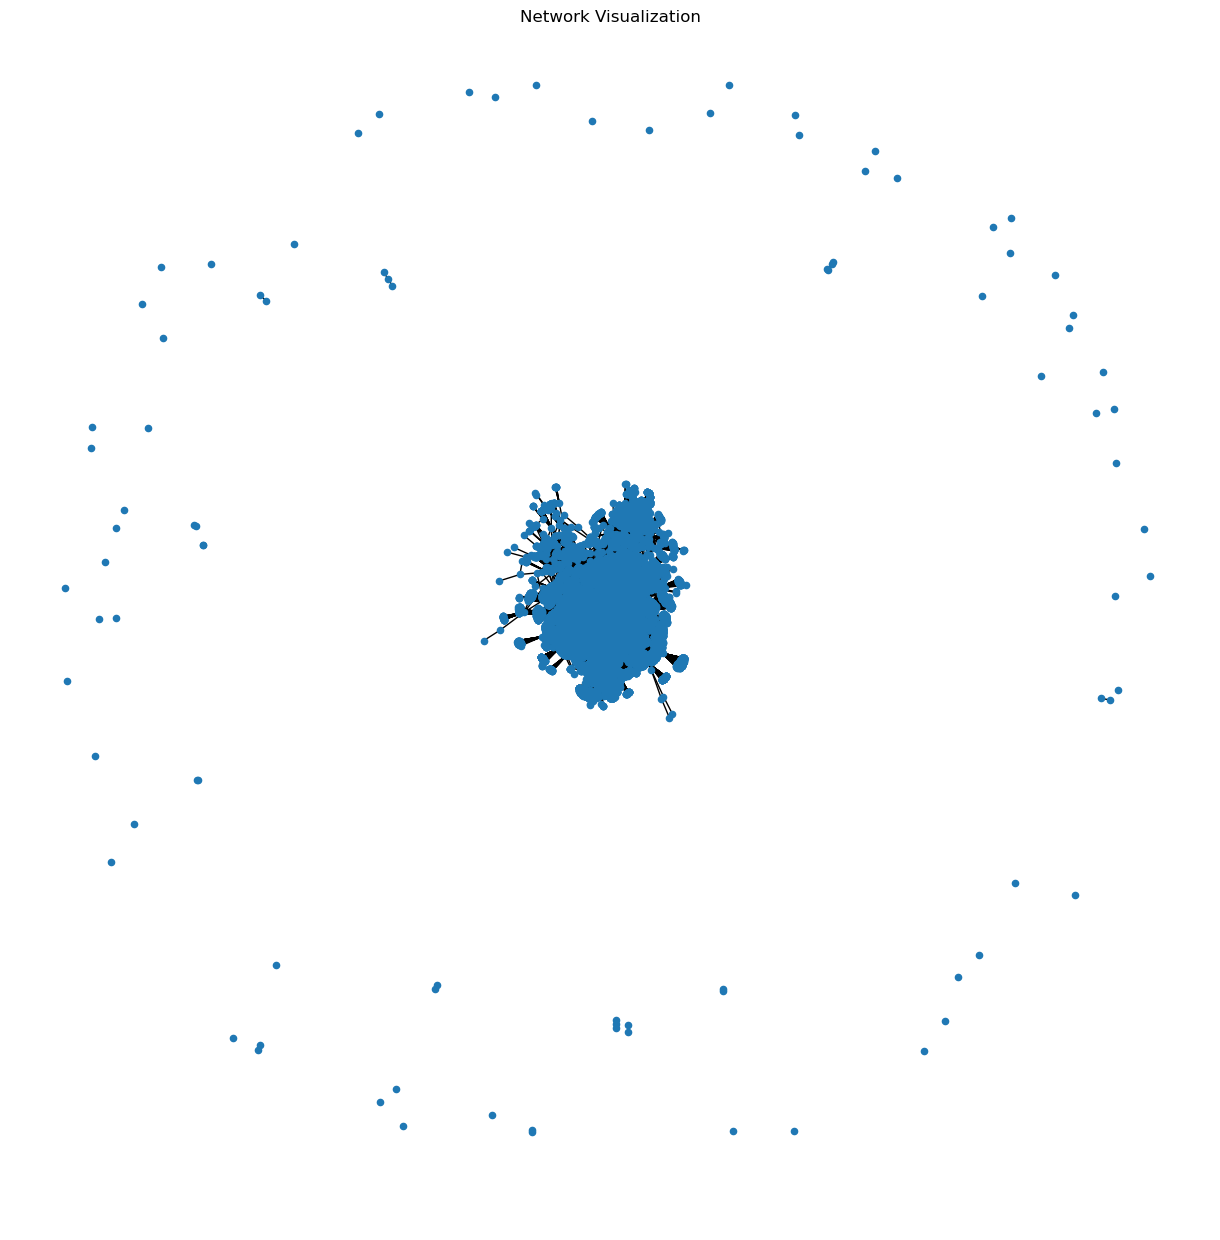

In [10]:
plt.figure(figsize=(12, 12))  # Set the size of the plot
nx.draw(G, node_size=20, font_size=8)
plt.title("Network Visualization")
plt.show()

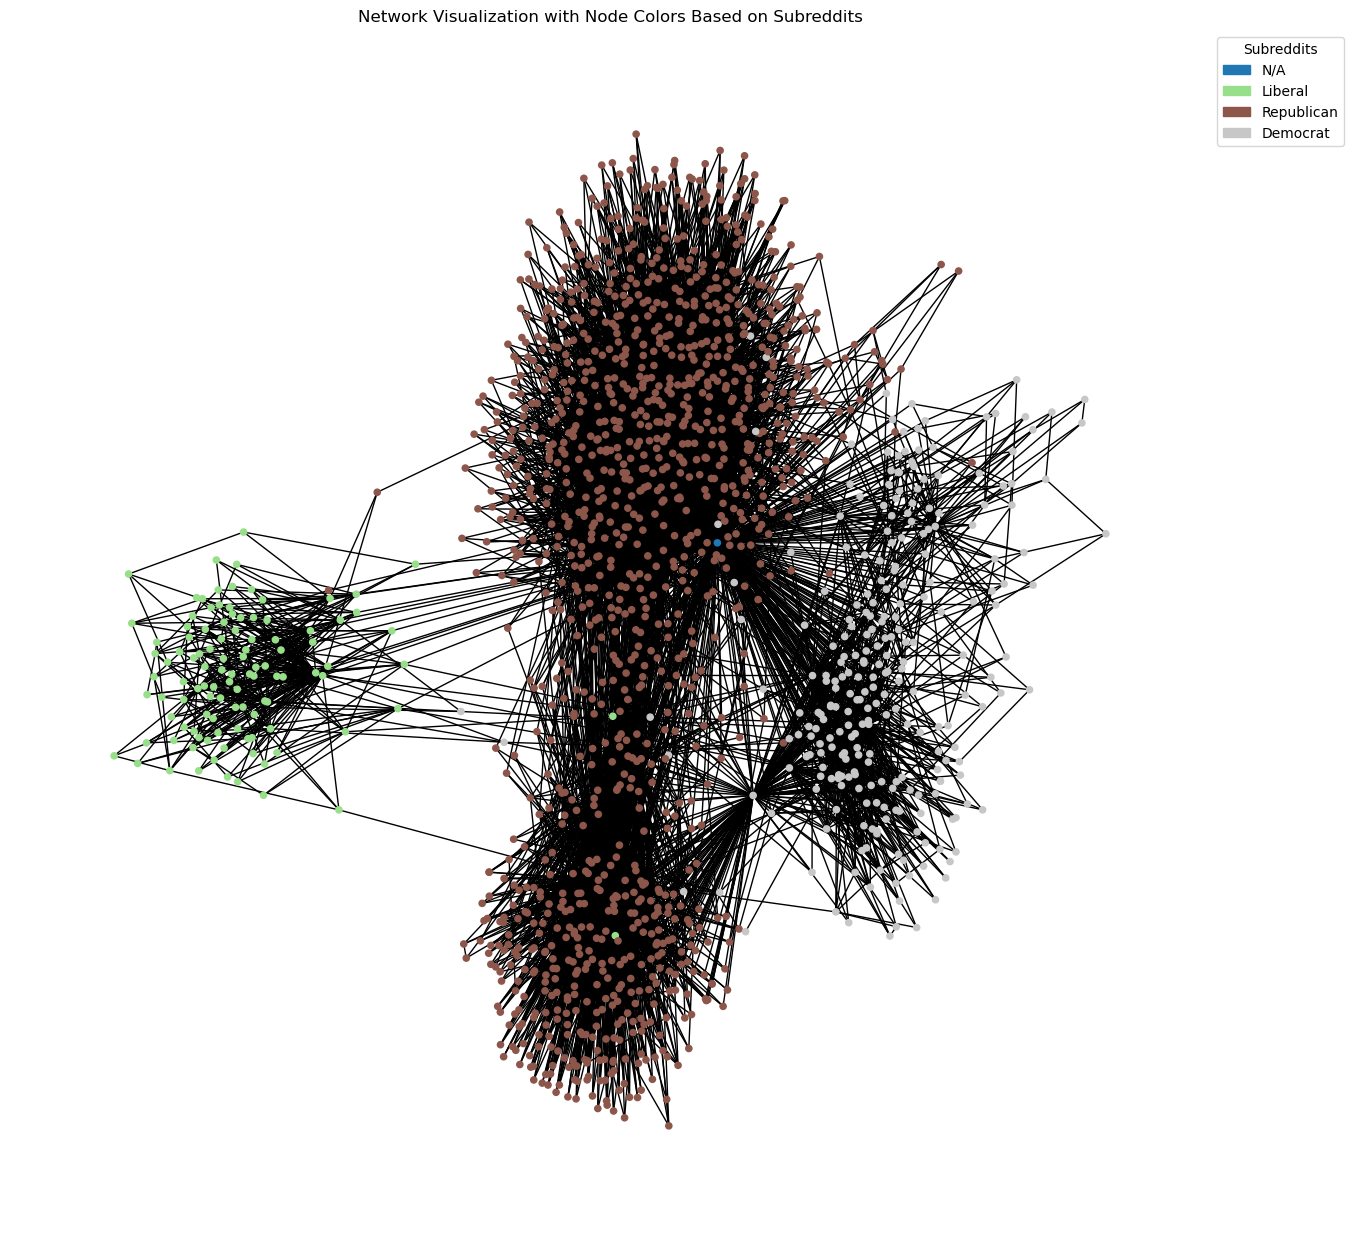

In [11]:
# Create a color map for unique subreddits in G_kcore
subreddit_list = [G_kcore.nodes[node].get('subreddit', 'N/A') for node in G_kcore.nodes]
subreddit_set = set(subreddit_list)
color_map = {subreddit: plt.cm.tab20(i / len(subreddit_set)) for i, subreddit in enumerate(subreddit_set)}

# Assign colors to nodes based on their subreddit attribute
node_colors = [color_map[G_kcore.nodes[node].get('subreddit', 'N/A')] for node in G_kcore.nodes()]

# Create a figure
plt.figure(figsize=(12, 12))

# Draw the graph
nx.draw(G_kcore, node_color=node_colors, with_labels=False, node_size=20, font_size=8)

# Create a legend
patch_list = []
for subreddit, color in color_map.items():
    patch = mpatches.Patch(color=color, label=subreddit)
    patch_list.append(patch)

# Add the legend to the plot
plt.legend(handles=patch_list, title='Subreddits', loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot with the legend
plt.title("Network Visualization with Node Colors Based on Subreddits")
plt.show()

In [12]:
len(set(G_kcore.nodes))

1601

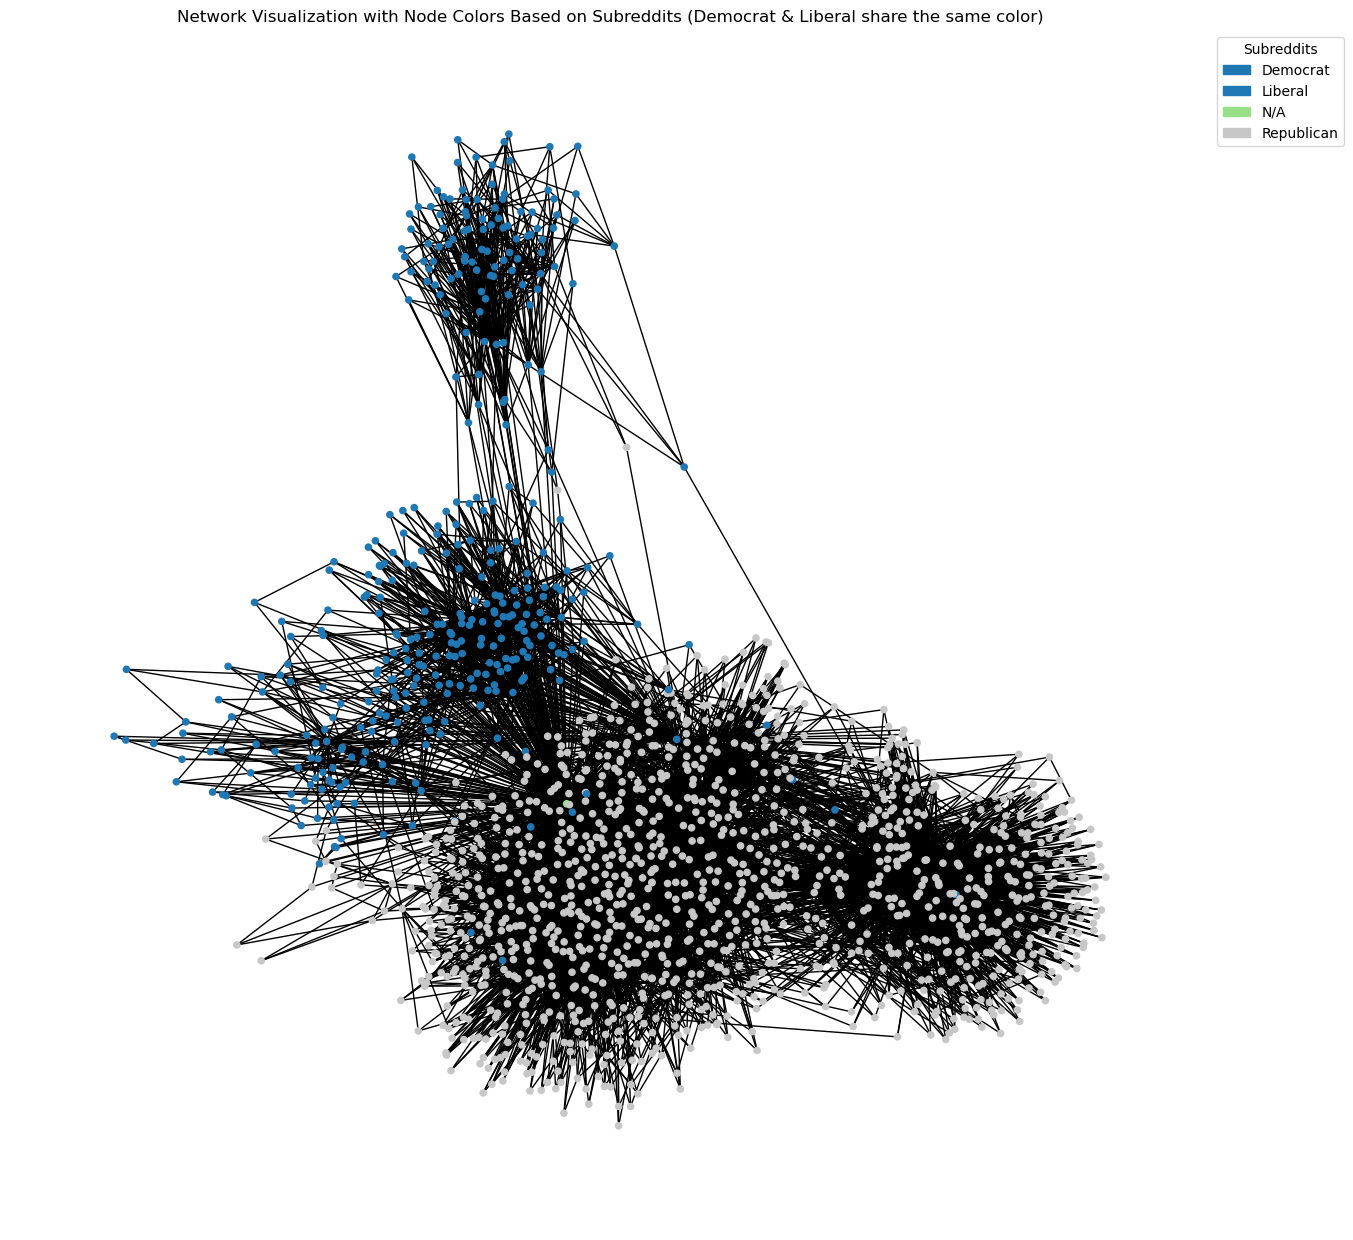

In [13]:
# Create a color map for unique subreddits in G_kcore, ensuring 'Democrat' and 'Liberal' share the same color
subreddit_list = [G_kcore.nodes[node].get('subreddit', 'N/A') for node in G_kcore.nodes]
subreddit_set = set(subreddit_list)

# Predefine a color for 'Democrat' and 'Liberal'
shared_color = plt.cm.tab20(0)  # Choose a color from the colormap

# Initialize color_map with 'Democrat' and 'Liberal' having the same color
color_map = {'Democrat': shared_color, 'Liberal': shared_color}

# Assign colors to other subreddits, skipping 'Democrat' and 'Liberal' since they are already assigned
for i, subreddit in enumerate(subreddit_set):
    if subreddit not in ['Democrat', 'Liberal']:  # Skip to avoid overwriting the shared color
        color_map[subreddit] = plt.cm.tab20((i + 1) / len(subreddit_set))  # Adjust color index to avoid reuse

# Assign colors to nodes based on their subreddit attribute, using the updated color map
node_colors = [color_map[G_kcore.nodes[node].get('subreddit', 'N/A')] for node in G_kcore.nodes()]

# Create a figure
plt.figure(figsize=(12, 12))

# Draw the graph with the updated node colors
nx.draw(G_kcore, node_color=node_colors, with_labels=False, node_size=20, font_size=8)

# Create a legend (adjust as needed to reflect the shared color correctly)
patch_list = []
for subreddit, color in color_map.items():
    patch = mpatches.Patch(color=color, label=subreddit)
    patch_list.append(patch)

plt.legend(handles=patch_list, title='Subreddits', loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Network Visualization with Node Colors Based on Subreddits (Democrat & Liberal share the same color)")
plt.show()


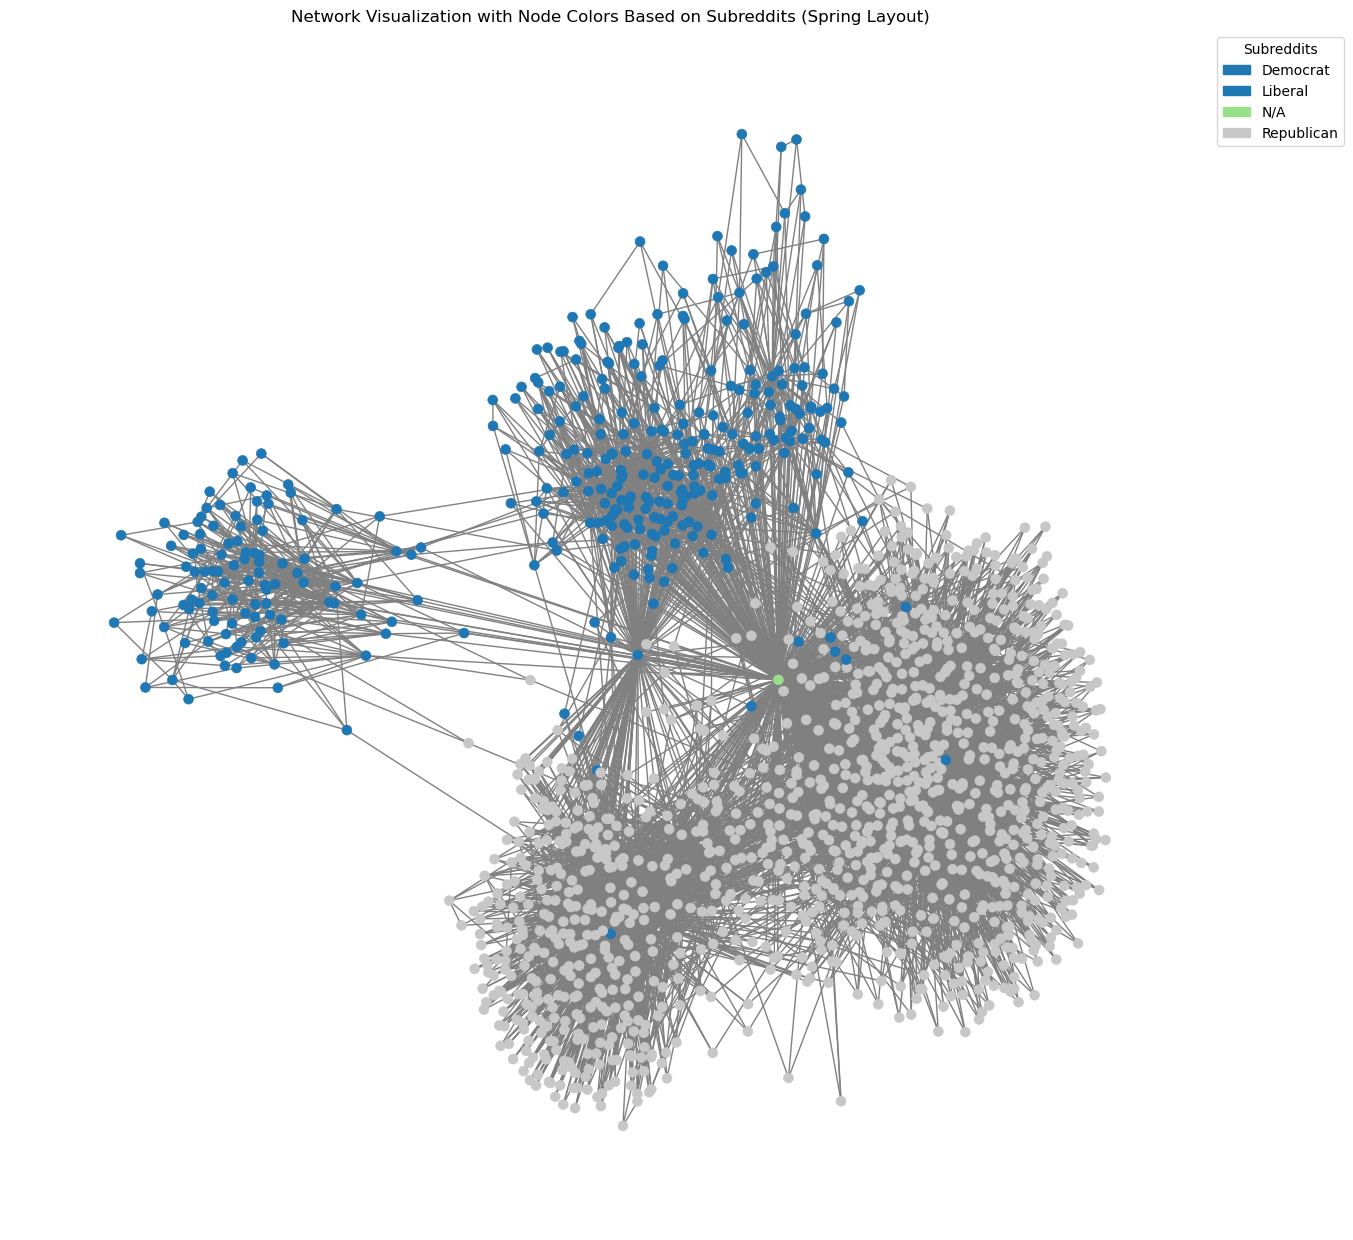

In [14]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches

# Adjust the spring layout visualization
pos = nx.spring_layout(G_kcore)  # Position nodes using a spring layout

# Predefine a color for 'Democrat' and 'Liberal' and ensure they share the same color in the color_map
shared_color = plt.cm.tab20(0)  # Choose a color from the colormap
color_map = {'Democrat': shared_color, 'Liberal': shared_color}

# Assign colors to other subreddits, ensuring unique colors but sharing between 'Democrat' and 'Liberal'
subreddit_list = [G_kcore.nodes[node].get('subreddit', 'N/A') for node in G_kcore.nodes()]
subreddit_set = set(subreddit_list)
for i, subreddit in enumerate(subreddit_set):
    if subreddit not in color_map:  # Check if not already assigned a color
        color_map[subreddit] = plt.cm.tab20((i + 1) / len(subreddit_set))  # Adjust color index to avoid reuse

# Assign colors to nodes based on their subreddit attribute
node_colors = [color_map[G_kcore.nodes[node].get('subreddit', 'N/A')] for node in G_kcore.nodes()]

# Create a figure
plt.figure(figsize=(12, 12))

# Draw the graph using the spring layout and updated node colors
nx.draw(G_kcore, pos, node_color=node_colors, with_labels=False, node_size=50, edge_color="gray", linewidths=0.5, font_size=8)

# Create a legend for subreddits
patch_list = []
for subreddit, color in color_map.items():
    patch = mpatches.Patch(color=color, label=subreddit)
    patch_list.append(patch)

plt.legend(handles=patch_list, title='Subreddits', loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Network Visualization with Node Colors Based on Subreddits (Spring Layout)")
plt.show()

In [15]:
len(G_kcore.nodes)

1601